# Create the model as in Tutorial 1: Forward Modelling

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s


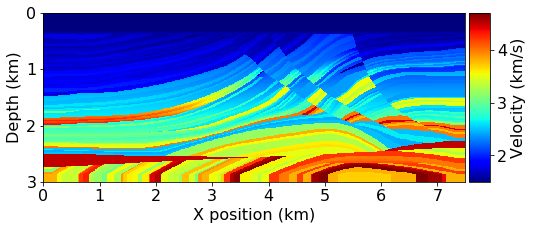

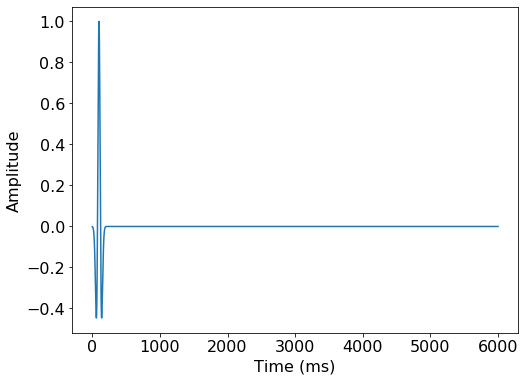

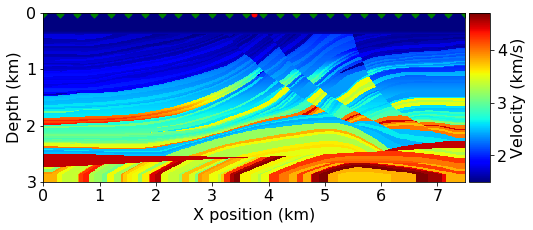

In [1]:
import numpy as np
%matplotlib inline

from examples.seismic import demo_model

def create_model(grid=None):
        return demo_model('marmousi2d-isotropic', data_path='/home/bruno/Repos/data',
                          grid=grid, nbpml=20)

#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, plot_velocity

# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :51] = 1.5
v[:, 51:] = 2.5

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
#model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
#              space_order=2, nbpml=10)

model = create_model()

plot_velocity(model)

model.shape

from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 6000.  # Simulation last 6 seconds (6000 ms)
dt = model.critical_dt  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

#NBVAL_IGNORE_OUTPUT
from examples.seismic import RickerSource

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# First, position source centrally in all dimensions, then set depth
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 20.  # Depth is 20m

# We can plot the time signature to see the wavelet
src.show()

#NBVAL_IGNORE_OUTPUT
from examples.seismic import Receiver

# Create symbol for 101 receivers
rec = Receiver(name='rec', grid=model.grid, npoint=101, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101)
rec.coordinates.data[:, 1] = 20.  # Depth is 20m

# We can now show the source and receivers within our domain:
# Red dot: Source location
# Green dots: Receiver locations (every 4th point)
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

# Create operators

In [2]:
# In order to represent the wavefield u and the square slowness we need symbolic objects 
# corresponding to time-space-varying field (u, TimeFunction) and 
# space-varying field (m, Function)
from devito import TimeFunction
from devito import ConditionalDimension

nt = time_range.num

nsnaps = 40            # desired number of equally spaced snaps
import math
factor = math.ceil(nt / nsnaps)

time_subsampled = ConditionalDimension(
    't_sub', parent=model.grid.time_dim, factor=factor)


# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)

usave = TimeFunction(name='usave', grid=model.grid, time_order=2, space_order=2,
                     save=(nt + factor - 1) // factor, time_dim=time_subsampled)

# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

# The PDE representation is as on paper
pde

damp(x, y)*Derivative(u(t, x, y), t) - Derivative(u(t, x, y), (x, 2)) - Derivative(u(t, x, y), (y, 2)) + Derivative(u(t, x, y), (t, 2))/vp(x, y)**2

In [3]:
# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as 
# a time marching updating equation known as a stencil using customized SymPy functions
from devito import Eq, solve

stencil = Eq(u.forward, solve(pde, u.forward))

In [4]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)

In [5]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator

op = Operator([stencil] + src_term + [Eq(usave, u)] + rec_term,
               subs=model.spacing_map)

op(time=nt - 2, dt=model.critical_dt)

Operator `Kernel` run in 9.80 s


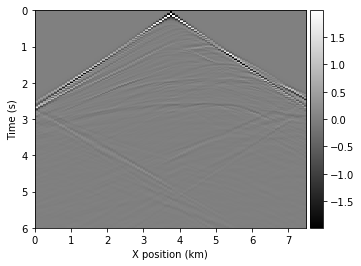

In [6]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, t0, tn)

In [7]:
assert np.isclose(np.linalg.norm(rec.data), 450, rtol=10)

# Save data

In [8]:
import os, sys

if os.path.isfile("usaveBruno.bin"):
    os.system("rm usaveBruno.bin")
    print("Removed usaveBruno.bin")
usave.data.tofile("usaveBruno.bin")
print("Saved new data")

Removed usaveBruno.bin
Saved new data


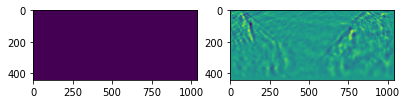

In [9]:
import matplotlib.pyplot as plt 

nb = model.nbpml

fobj = open("usaveBruno.bin", "rb")
snaps = np.fromfile(fobj, dtype=np.float32)
snaps = np.reshape(snaps, (nsnaps, model.shape[0] + 2*nb, model.shape[1] + 2*nb))
fobj.close()

plt.rcParams['figure.figsize'] = (10, 5)  # Increases figure size

imcnt = 1 # Image counter for plotting
plot_num = 2 # Number of images to plot

for i in range(0, nsnaps, int(nsnaps/plot_num)):
   plt.subplot(1,plot_num+1, imcnt+1);
   imcnt = imcnt + 1
   plt.imshow(np.transpose(snaps[i,:,:]))

plt.show() 

# Create gif
.      

.

.

.

.

.

.

.

.

In [ ]:
import matplotlib.pyplot as plt

nb = model.nbpml

fobj = open("usaveBruno.bin", "rb")
snaps = np.fromfile(fobj, dtype=np.float32)
snaps = np.reshape(snaps, (nsnaps, model.shape[0] + 2*nb, model.shape[1] + 2*nb))
fobj.close()

plt.rcParams['figure.figsize'] = (10, 5)  # Increases figure size

if not os.path.isdir("snaps"):
    os.system("mkdir snaps")
    print("Created dir snaps")
else:
    os.system("rm snaps/*")
    print("Removed files from snaps/")
    
if os.path.isfile("fmMovie.gif"):
    os.system("rm fmMovie.gif")
    print("Removed fmMovie.gif")
    
# Create images
for i in range(nsnaps):
    print('\rCreating image %d of %d'%(i+1, nsnaps), end="\r")
    plt.imshow(np.transpose(snaps[i, :, :]))
    plt.savefig("snaps/fig%s.png"%str(i).rjust(4, '0'), dpi=300)



Removed files from snaps/


# Functions for animating

In [ ]:
# Functions for animating
def animateImageMagick(gifdelay):
    print()
    print("Animating...")
    os.system("convert -delay " + str(gifdelay) + " -loop 0 snaps/*.png fmMovie.gif")

    # Prompt to remove images
    inp = input("Remove snaps?[y for yes]")
    if inp == "y":
        print("Removing files...")
        os.system("mv snaps/fmMovie.gif .")
        print("Removing 'snaps/'")
        os.system("rm -r 'snaps/'")
        print("Done.")
        
# FPS passed as argument (recommended for 40 images: 10fps)
def animateFFmpeg(fps):
    print()
    print("Animating...")
    os.system("ffmpeg -r " + str(fps) + " -i snaps/fig%04d.png out.mp4")
    
    # Prompt to remove images
    inp = input("Remove snaps?[y for yes]")
    if inp == "y":
        print("Removing files...")
        os.system("mv snaps/fmMovie.gif .")
        print("Removing 'snaps/'")
        os.system("rm -r 'snaps/'")
        print("Done.")

In [ ]:
# Animating
animatingTool = "ffmpeg"
inp = input("Animate?[y for yes]")
if inp == "y":
    if animatingTool is "imagemagick":
        animateImageMagick(15)
    elif animatingTool is "ffmpeg":
        animateFFmpeg(10)